In [4]:
from google.colab import files
uploaded = files.upload()

import json
with open('kaggle.json') as f:
  kaggle_api = json.load(f)
  
import os
os.environ['KAGGLE_USERNAME'] = kaggle_api['username']
os.environ['KAGGLE_KEY'] = kaggle_api['key']

Saving kaggle.json to kaggle (1).json


In [5]:
!kaggle competitions download -c titanic

  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 26.0MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.33MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 48.4MB/s]


In [0]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV,train_test_split
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

import matplotlib.pyplot as plt
%matplotlib inline

seed = 8888

## 1. Load the data

In [8]:
train_df = pd.read_csv("train.csv",header=0)
test_df = pd.read_csv("test.csv",header=0)
print( 'train and test data shape = ', train_df.shape, test_df.shape)
print('label = ', set(train_df.columns) - set(test_df.columns))

train and test data shape =  (891, 12) (418, 11)
label =  {'Survived'}


In [9]:
train_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


## 2. Feature engineering

In [0]:
import math
def impute_age(row):
    if math.isnan(row["Age"]):
        if row['Sex'] == 'female' and row['Pclass'] == 1:
            return 34.61
        elif row['Sex'] == 'female' and row['Pclass'] == 2:
            return 28.72
        elif row['Sex'] == 'female' and row['Pclass'] == 3:
            return 21.75
        elif row['Sex'] == 'male' and row['Pclass'] == 1:
            return 41.28
        elif row['Sex'] == 'male' and row['Pclass'] == 2:
            return 30.74
        elif row['Sex'] == 'male' and row['Pclass'] == 3:
            return 26.51
        else:
            return 0.
    
    else:
        return row["Age"]      
    
    
def impute_fare(row):
    if math.isnan(row["Fare"]):
        if row['Pclass'] == 1:
            return 84.15
        elif row['Pclass'] == 2:
            return 20.66
        elif row['Pclass'] == 3:
            return 13.68
        else:
            return 0.
    
    else:
        return row["Fare"]      
    

train_df['LastName'] = train_df['Name'].map(lambda x: x.split(",")[0])
agg = train_df[['LastName', 'Survived']].groupby(['LastName'], as_index=False).sum()
LastNameSurvivors = list(agg[agg['Survived'] > 0]['LastName'])

def create_features(df):
    df = df.drop(["Ticket","Cabin"],axis=1)
    
    df["Age"] = df.apply(lambda row: impute_age(row),axis=1)
    df["Fare"] = df.apply(lambda row: impute_fare(row),axis=1)
    
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    df['LastName'] = df['Name'].map(lambda x: x.split(",")[0])
    df['LastNameSurvived'] = df['LastName'].map(lambda x: 1 if x in LastNameSurvivors else 0)

    df['Age_bucket'] =  df.Age
    df.loc[ df['Age'] <= 16, 'Age_bucket'] = 0
    df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age_bucket'] = 1
    df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age_bucket'] = 2
    df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age_bucket'] = 3
    df.loc[df['Age'] > 64, 'Age_bucket'] = 4
    df['Age_bucket'] = df['Age_bucket'].astype(int)

    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

    df['Embarked'] = df['Embarked'].fillna("S")

    df['Fare_bucket'] = df.Fare
    df.loc[ df['Fare'] <= 8.05, 'Fare_bucket'] = 0
    df.loc[(df['Fare'] > 8.05) & (df['Fare'] <= 15.742), 'Fare_bucket'] = 1
    df.loc[(df['Fare'] > 15.742) & (df['Fare'] <= 33.375), 'Fare_bucket']   = 2
    df.loc[ df['Fare'] > 33.375, 'Fare_bucket'] = 3
    df['Fare_bucket'] = df['Fare_bucket'].astype(int)
    
    df['Age_bucket*Class'] = df.Age_bucket * df.Pclass
    df['Fare_bucket*Class'] = df.Fare_bucket * df.Pclass
    
    return df

# categories should be strings before pd.dummies
def categories_to_str(df, categorical_features):
    for col in categorical_features:
        df[col] = df[col].astype(str)
    return df

# categories should be int if not turned to dummies
def categories_to_int(df, categorical_features):
    for col in categorical_features:
        df[col] = df[col].astype(int)
    return df

def categories_encoded(train, test, label, categorical_features):
    
    # encode label first
    label_le = LabelEncoder()
    train[label] = label_le.fit_transform(train[label].values)

    catego_le = LabelEncoder()
    for feature in categorical_features:
        train[feature] = catego_le.fit_transform(train[feature].values)
        test[feature] = catego_le.transform(test[feature].values)
    return train, test


def categories_to_dummies(train, test, categorical_features):
        
    # categories should be strings before applying pd.dummies
    for feature in categorical_features:
        train[feature] = train[feature].astype(str)
        test[feature] = test[feature].astype(str)
        
    train_dummies = train[categorical_features]
    test_dummies  = test[categorical_features]
    
    train_dummies = pd.get_dummies(train_dummies)
    test_dummies = pd.get_dummies(test_dummies)
    
    return train_dummies, test_dummies


def preprocess(train,test,_id,label,
               categorical_features,numerical_features,
               categories_to_dummies_bool = True
              ):

    train = create_features(train)
    test = create_features(test)
    print('DF shape after feature engineering: ', train.shape, test.shape)
    
    train, test = categories_encoded(train, test, label, categorical_features)
    print('DF categorical features shape after label encoded: ', train.shape, test.shape)

    if len(categorical_features) > 0:
        if categories_to_dummies_bool:

            train = categories_to_str(train, categorical_features)
            test = categories_to_str(test, categorical_features)
            print('Categorical features are transformed as string.')

            train_dummies, test_dummies = categories_to_dummies(train, test,categorical_features)
            print('DF categorical features shape after turned to dummies: ', train_dummies.shape, test_dummies.shape)

            if len(numerical_features) > 0:
                train = pd.concat([train[[df_id] + [label] + numerical_features],train_dummies], axis=1)
                test = pd.concat([test[[df_id] + numerical_features],test_dummies], axis=1)
            else:
                train = pd.concat([train[[df_id] + [label] ],train_dummies], axis=1)
                test = pd.concat([test[[df_id]],test_dummies], axis=1)

        else: #categories are not turned into dummies
            if len(numerical_features) > 0:
                train = pd.concat([train[[df_id] + [label] + numerical_features],train[categorical_features]], axis=1)
                test = pd.concat([test[[df_id] + numerical_features],test[categorical_features]], axis=1)
            else:
                train = pd.concat([train[[df_id] + [label] ],train[categorical_features]], axis=1)
                test = pd.concat([test[[df_id]],test[categorical_features]], axis=1)
    else:
        train = pd.concat([train[[df_id] + [label] ],train[numerical_features]], axis=1)
        test = pd.concat([test[[df_id]],test[numerical_features]], axis=1)

    print('DF final shape: ',train.shape, test.shape)
    return train, test

## 3. Training

In [0]:
def training(models, train, final_features, test_size = 0.3, n_splits = 5, seed = 8888):
    
    X_train, X_test, y_train, y_test = train_test_split(train[final_features], train[label],
                                                    test_size=test_size, random_state=seed)
    
    trained_model={}
    metrics_result = {}
    
    for item in models:
        grid_search = GridSearchCV(
                            estimator = item['name'], param_grid = item['param_grid'], 
                            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed),
                            scoring = 'accuracy'
                            #scoring = 'roc_auc'
                            )

        grid_search.fit(train[final_features], train[label])#X_train,y_train) 

        best_param = grid_search.best_params_
        clf = item['name'].set_params(**best_param) 

        model=clf.fit(X_train,y_train)
        pred_train = model.predict(X_train)

        trained_model[clf.__class__.__name__]=model
        pred_test=model.predict(X_test)
        
        accuracy_train = accuracy_score(y_train,pred_train)
        accuracy_test = accuracy_score(y_test,pred_test)
        trained_model
        metrics_result[clf.__class__.__name__] = [accuracy_train]
        metrics_result[clf.__class__.__name__].append(accuracy_test)

        #metrics
        print("Train : {}:{}".format(clf.__class__.__name__, accuracy_train))
        print("Test  : {}:{}".format(clf.__class__.__name__, accuracy_test))
        print()
        
    return trained_model, metrics_result

def training_nestedCV(models, train, final_features, test_size = 0.3, n_splits = 5, seed = 8888):
    
    X = train[final_features]
    y = train[label]
    
    trained_model={}
    metrics_result = {}
    
    for item in models:
        
        outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
        inner_cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

        train_outer_scores = []
        test_outer_scores = []
        # outer folds
        
        best_model = None
        max_test_score = 0
        for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
            print('[Outer fold {}/{}]'.format((i + 1),n_splits))
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            gs = GridSearchCV(
                    estimator = item['name'], param_grid = item['param_grid'], 
                    cv = inner_cv,
                    scoring = 'accuracy'
                    #scoring = 'roc_auc'
                    )
        
            gs.fit(X_train, y_train)
            best_clf = gs.best_estimator_
            best_clf.fit(X_train, y_train)    
            
            train_outer_scores.append(best_clf.score(X_train, y_train))
            test_outer_scores.append(best_clf.score(X_test, y_test))
            
            if test_outer_scores[-1] > max_test_score:
                max_test_score = test_outer_scores[-1]
                best_model = best_clf
            
        accuracy_train = np.mean(train_outer_scores)
        accuracy_test = np.mean(test_outer_scores)
        
        trained_model[item['name'].__class__.__name__]=best_model
        metrics_result[item['name'].__class__.__name__] = [accuracy_train]
        metrics_result[item['name'].__class__.__name__].append(accuracy_test)
        
        print("Train : {}:{}".format(item['name'].__class__.__name__, accuracy_train))
        print("Test  : {}:{}".format(item['name'].__class__.__name__, accuracy_test))
        print()

    return trained_model, metrics_result


def create_submission(trained_model,model_name,
                      train, test,
                      categorical_features,numerical_features,
                      to_csv = False,
                      prefix = None,
                      categories_to_dummies_bool = True):
    
    train,test = preprocess(train,test,"PassengerId","Survived",
               categorical_features,numerical_features,
               categories_to_dummies_bool)
    
    final_features =  list(set(train.columns)-set([label,df_id]))
    
    model = trained_model[model_name]
    model.fit(train[final_features], train[label])
    
    prediction = model.predict(test[final_features])
    
    submission = pd.DataFrame(test[df_id]).join(pd.DataFrame(prediction))
    submission.columns = ["PassengerId","Survived"]
    
    if to_csv:
        if prefix:
            submission.to_csv(prefix + model_name + '.csv', index=False)
        else:
            submission.to_csv(model_name + '.csv', index=False)

    print('# of predicted survivors: {}, avg: {}'.format(sum(submission['Survived']),sum(submission['Survived'])/len(submission['Survived'])))
    return sum(submission['Survived'])

grid_n_estimator = [10, 20, 50, 100]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, 20, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [seed]

models=[
    {
        "name":ensemble.AdaBoostClassifier(),
        "param_grid":
        {
            'n_estimators': grid_n_estimator, 
            'learning_rate': grid_learn, 
            'random_state': grid_seed
        }
    },
    {
        "name":XGBClassifier(),
        "param_grid":
            {
            'learning_rate': grid_learn, 
            'max_depth': [1,2,4,6,8,10],
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }
    },
    {
        "name":svm.SVC(),
        "param_grid":{
            'C': [1,2,3,4,5], 
            'gamma': grid_ratio, 
            'decision_function_shape': ['ovo', 'ovr'], 
            'probability': [True],
            'random_state': grid_seed
             }
    },
    {
        "name":ensemble.RandomForestClassifier(),
        "param_grid":{
            'n_estimators': grid_n_estimator, 
            'criterion': grid_criterion, 
            'max_depth': grid_max_depth, 
            'oob_score': [True], 
            'random_state': grid_seed
             }
    },
    
    {
        "name":ensemble.BaggingClassifier(),
        "param_grid":{
            'n_estimators': grid_n_estimator, 
            'max_samples': grid_ratio, 
            'random_state': grid_seed
            }
    },
    {
        "name": linear_model.LogisticRegressionCV(),
        "param_grid":{
            'fit_intercept': grid_bool, 
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
            'random_state': grid_seed
            #'class_weight':[None,'Balanced']
           }
    }
]


def voting_classifier(train,test,
                      categorical_features,numerical_features,
                      models_all,combination_idx,
                      include_all_models=True,
                      to_csv=False,
                      model_name = 'voting_classifier',
                      ):
    
    if include_all_models:
        voting_classifier = VotingClassifier(estimators=[
        ('AdaBoostClassifier', models_all[combination_idx]['AdaBoostClassifier']),
        ('XGBClassifier', models_all[combination_idx]['XGBClassifier']),
        ('SVC', models_all[combination_idx]['SVC']),
        ('RandomForestClassifier', models_all[combination_idx]['RandomForestClassifier']),
        ('BaggingClassifier', models_all[combination_idx]['BaggingClassifier']),
        ('LogisticRegressionCV', models_all[combination_idx]['LogisticRegressionCV']),
    ],voting='hard')
        
    else:
        voting_classifier = VotingClassifier(estimators=[
        ('AdaBoostClassifier', models_all[combination_idx]['AdaBoostClassifier']),
        ('XGBClassifier', models_all[combination_idx]['XGBClassifier']),
        ('LogisticRegressionCV', models_all[combination_idx]['LogisticRegressionCV']),
    ],voting='hard')
        
    train, test = preprocess(train,test,"PassengerId","Survived",
                            categorical_features,numerical_features,
                            categories_to_dummies_bool)
    
    final_features =  list(set(train.columns)-set([label,df_id]))
        
    voting_classifier = voting_classifier.fit(train[final_features], train[label])
    prediction = voting_classifier.predict(test[final_features])
    
    if to_csv:
        submission = pd.DataFrame(test[df_id]).join(pd.DataFrame(prediction))
        submission.columns = ["PassengerId","Survived"]
        submission.to_csv(model_name + '.csv', index=False)
    
    print('predicted # of survivors = ', sum(prediction))

all_possible_features = [
       'PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'LastName',
       'LastNameSurvived', 'FamilySize',
       'Age_bucket', 'Fare_bucket','Age_bucket*Class','Fare_bucket*Class']

df_id = "PassengerId"
label = "Survived"

### 3.a. Use Individual features

In [13]:
"""
features = [
[cat1,num1],
[cat2,num2]
.
.
.
]
"""

'\nfeatures = [\n[cat1,num1],\n[cat2,num2]\n.\n.\n.\n]\n'

### 3.a.i. Numerics are continuous

In [0]:
df_id = "PassengerId"
label = "Survived"

In [0]:
features = [
    [[],["Age"]],
    [[],["Fare"]],
    [[],["SibSp"]],
    [[],["Parch"]],
    [[],["FamilySize"]],
    [[],["Age_bucket*Class"]],
    [[],["Fare_bucket*Class"]]
]

In [16]:
# all interested features: univariate
# categories are bool
# numerical features are continuous

models_all = []
metrics_all = []
categories_to_dummies_bool = False

for feature_list in features:
    categorical_features = feature_list[0]
    numerical_features = feature_list[1]

    train, test = preprocess(train_df,test_df,df_id,label,
                            categorical_features,numerical_features,
                            categories_to_dummies_bool)

    final_features =  list(set(train.columns)-set([label,df_id]))
    len(final_features)

    trained_model, metrics_result = training(models, train,final_features,  n_splits=5)
    
    models_all.append(trained_model)
    metrics_all.append(metrics_result)

DF shape after feature engineering:  (891, 19) (418, 18)
DF categorical features shape after label encoded:  (891, 19) (418, 18)
DF final shape:  (891, 3) (418, 2)
Train : AdaBoostClassifier:0.6548956661316212
Test  : AdaBoostClassifier:0.5970149253731343

Train : XGBClassifier:0.6773675762439807
Test  : XGBClassifier:0.6082089552238806

Train : SVC:0.6757624398073836
Test  : SVC:0.6156716417910447

Train : RandomForestClassifier:0.6869983948635634
Test  : RandomForestClassifier:0.5932835820895522

Train : BaggingClassifier:0.7062600321027287
Test  : BaggingClassifier:0.6194029850746269

Train : LogisticRegressionCV:0.6356340288924559
Test  : LogisticRegressionCV:0.5708955223880597

DF shape after feature engineering:  (891, 19) (418, 18)
DF categorical features shape after label encoded:  (891, 19) (418, 18)
DF final shape:  (891, 3) (418, 2)
Train : AdaBoostClassifier:0.7255216693418941
Test  : AdaBoostClassifier:0.6231343283582089

Train : XGBClassifier:0.7800963081861958
Test  : XG

In [0]:
features_label =[str(feature_list[1]) for feature_list in features]

In [0]:
models_test_result = {}
for combination in metrics_all:
    for model in combination:
        if model not in models_test_result.keys():
             models_test_result[model] = []
        models_test_result[model].append(combination[model][1])

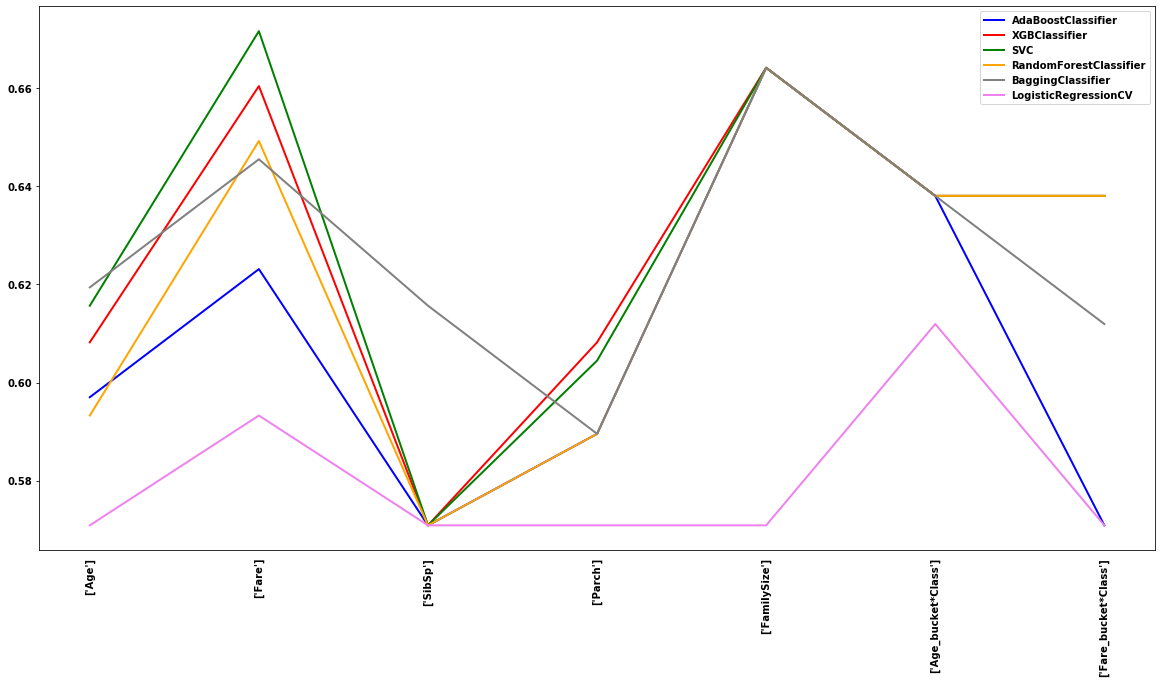

In [19]:
color_list = ['blue','red','green','orange','gray','violet']
plt.figure(figsize=(20,10))
x = list(range(len(features)))
for (model,color) in zip(models_test_result.keys(),color_list):
    plt.plot(x, models_test_result[model], label = model, color=color, linewidth=2.0)
plt.legend()
plt.xticks(list(range(len(features_label))), features_label, rotation='vertical')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True)  # labels along the bottom edge are off

### 3.a.ii. Numerics (Age and Fare) are bucketed

In [20]:
features = [
    [[],["Age_bucket"]],
    [[],["Fare_bucket"]]
]

models_all = []
metrics_all = []
categories_to_dummies_bool = False

for feature_list in features:
    categorical_features = feature_list[0]
    numerical_features = feature_list[1]

    train, test = preprocess(train_df,test_df,df_id,label,
                            categorical_features,numerical_features,
                            categories_to_dummies_bool)

    final_features =  list(set(train.columns)-set([label,df_id]))
    len(final_features)

    trained_model, metrics_result = training(models, train,final_features,  n_splits=5)
    
    models_all.append(trained_model)
    metrics_all.append(metrics_result)


DF shape after feature engineering:  (891, 19) (418, 18)
DF categorical features shape after label encoded:  (891, 19) (418, 18)
DF final shape:  (891, 3) (418, 2)
Train : AdaBoostClassifier:0.6484751203852327
Test  : AdaBoostClassifier:0.5783582089552238

Train : XGBClassifier:0.6484751203852327
Test  : XGBClassifier:0.5783582089552238

Train : SVC:0.6484751203852327
Test  : SVC:0.5783582089552238

Train : RandomForestClassifier:0.6484751203852327
Test  : RandomForestClassifier:0.5783582089552238

Train : BaggingClassifier:0.6484751203852327
Test  : BaggingClassifier:0.5783582089552238

Train : LogisticRegressionCV:0.6356340288924559
Test  : LogisticRegressionCV:0.5708955223880597

DF shape after feature engineering:  (891, 19) (418, 18)
DF categorical features shape after label encoded:  (891, 19) (418, 18)
DF final shape:  (891, 3) (418, 2)
Train : AdaBoostClassifier:0.6902086677367576
Test  : AdaBoostClassifier:0.5932835820895522

Train : XGBClassifier:0.6902086677367576
Test  : XG

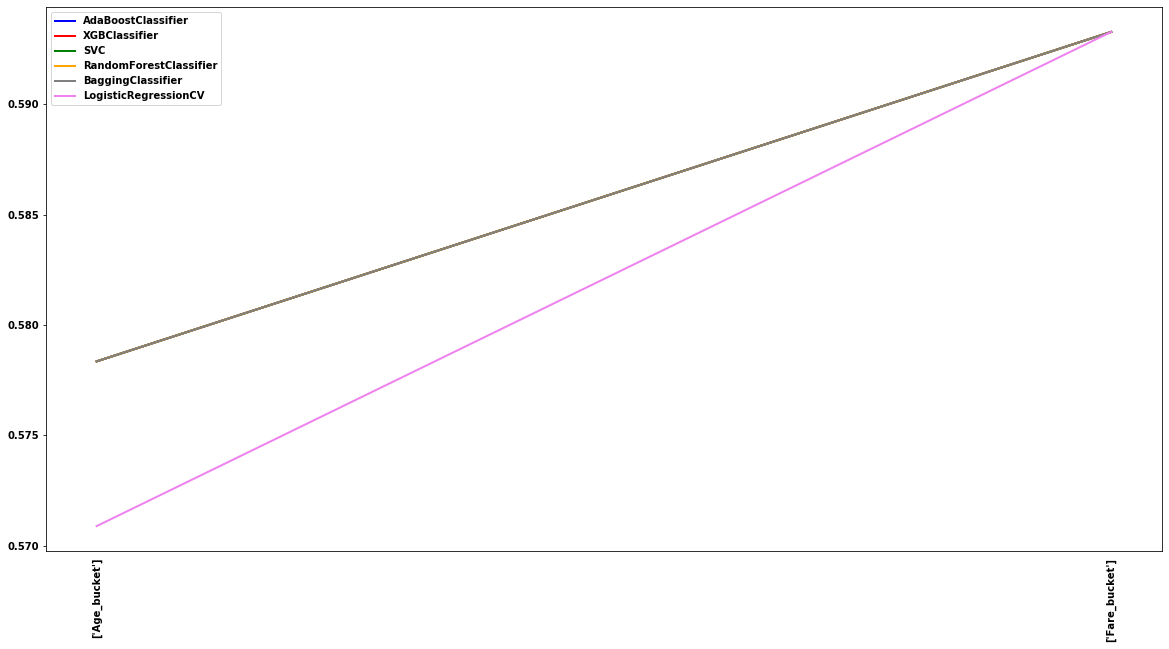

In [21]:
features_label =[str(feature_list[1]) for feature_list in features]

models_test_result = {}
for combination in metrics_all:
    for model in combination:
        if model not in models_test_result.keys():
             models_test_result[model] = []
        models_test_result[model].append(combination[model][1])

color_list = ['blue','red','green','orange','gray','violet']
plt.figure(figsize=(20,10))
x = list(range(len(features)))
for (model,color) in zip(models_test_result.keys(),color_list):
    plt.plot(x, models_test_result[model], label = model, color=color, linewidth=2.0)
plt.legend()
plt.xticks(list(range(len(features_label))), features_label, rotation='vertical')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True)  # labels along the bottom edge are off

* Numerics (Age and Fare) are better as continuous variables rather than bucketed
* Age_bucket, Fare_bucket, FamilySize, Age_bucket*Class are important

### 3.a.iii. Categories are NOT turned to dummies

In [0]:
categorical_features = ["Sex","Embarked","Title","IsAlone","Pclass"]

In [23]:
features = [
    [["Sex"],[]],
    [["Embarked"],[]],
    [["Title"],[]],
    [["IsAlone"],[]],
    [["Pclass"],[]]
]

models_all = []
metrics_all = []
categories_to_dummies_bool = False

for feature_list in features:
    categorical_features = feature_list[0]
    numerical_features = feature_list[1]

    train, test = preprocess(train_df,test_df,df_id,label,
                            categorical_features,numerical_features,
                            categories_to_dummies_bool)

    final_features =  list(set(train.columns)-set([label,df_id]))
    len(final_features)

    trained_model, metrics_result = training(models, train,final_features,  n_splits=5)
    
    models_all.append(trained_model)
    metrics_all.append(metrics_result)


DF shape after feature engineering:  (891, 19) (418, 18)
DF categorical features shape after label encoded:  (891, 19) (418, 18)
DF final shape:  (891, 3) (418, 2)
Train : AdaBoostClassifier:0.7945425361155698
Test  : AdaBoostClassifier:0.7686567164179104

Train : XGBClassifier:0.7945425361155698
Test  : XGBClassifier:0.7686567164179104

Train : SVC:0.7945425361155698
Test  : SVC:0.7686567164179104

Train : RandomForestClassifier:0.7945425361155698
Test  : RandomForestClassifier:0.7686567164179104

Train : BaggingClassifier:0.7945425361155698
Test  : BaggingClassifier:0.7686567164179104

Train : LogisticRegressionCV:0.7945425361155698
Test  : LogisticRegressionCV:0.7686567164179104

DF shape after feature engineering:  (891, 19) (418, 18)
DF categorical features shape after label encoded:  (891, 19) (418, 18)
DF final shape:  (891, 3) (418, 2)
Train : AdaBoostClassifier:0.6468699839486356
Test  : AdaBoostClassifier:0.6119402985074627

Train : XGBClassifier:0.6468699839486356
Test  : XG

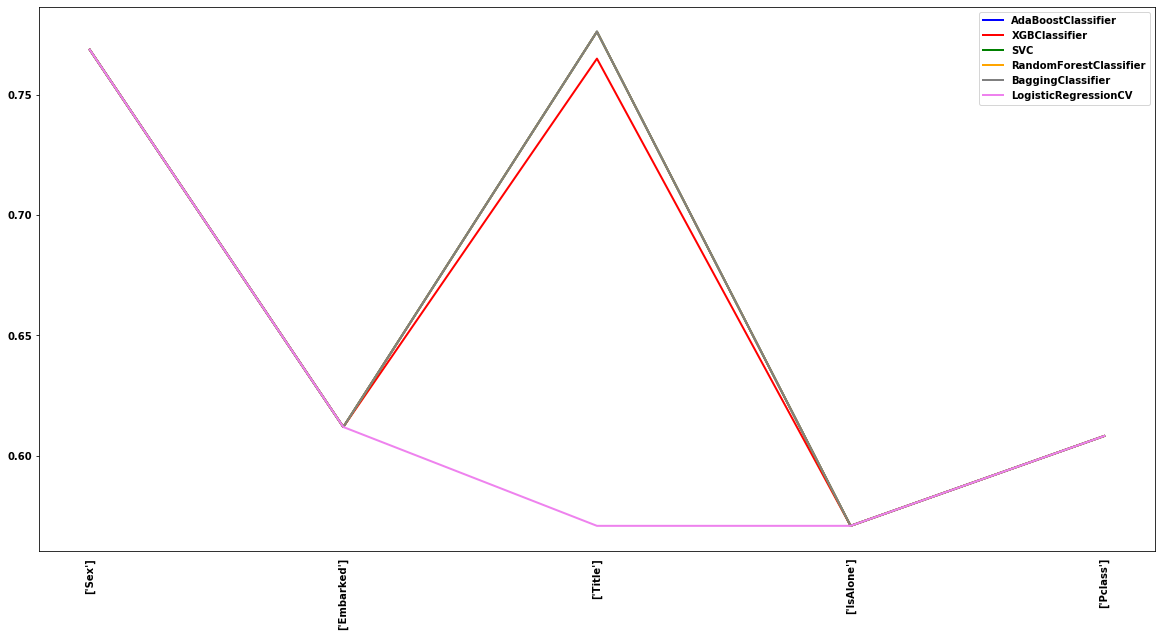

In [24]:
features_label =[str(feature_list[0]) for feature_list in features]

models_test_result = {}
for combination in metrics_all:
    for model in combination:
        if model not in models_test_result.keys():
             models_test_result[model] = []
        models_test_result[model].append(combination[model][1])

color_list = ['blue','red','green','orange','gray','violet']
plt.figure(figsize=(20,10))
x = list(range(len(features)))
for (model,color) in zip(models_test_result.keys(),color_list):
    plt.plot(x, models_test_result[model], label = model, color=color, linewidth=2.0)
plt.legend()
plt.xticks(list(range(len(features_label))), features_label, rotation='vertical')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True)  # labels along the bottom edge are off

### 3.a.iiiii. Categories are turned into dummies

In [25]:
features = [
    [["Sex"],[]],
    [["Embarked"],[]],
    [["Title"],[]],
    [["IsAlone"],[]],
    [["Pclass"],[]]
]

models_all = []
metrics_all = []
categories_to_dummies_bool = True

for feature_list in features:
    
    categorical_features = feature_list[0]
    numerical_features = feature_list[1]
    print(categorical_features)

    train, test = preprocess(train_df,test_df,df_id,label,
                            categorical_features,numerical_features,
                            categories_to_dummies_bool)

    final_features =  list(set(train.columns)-set([label,df_id]))
    len(final_features)

    trained_model, metrics_result = training(models, train,final_features,  n_splits=5)
    
    models_all.append(trained_model)
    metrics_all.append(metrics_result)


['Sex']
DF shape after feature engineering:  (891, 19) (418, 18)
DF categorical features shape after label encoded:  (891, 19) (418, 18)
Categorical features are transformed as string.
DF categorical features shape after turned to dummies:  (891, 2) (418, 2)
DF final shape:  (891, 4) (418, 3)
Train : AdaBoostClassifier:0.7945425361155698
Test  : AdaBoostClassifier:0.7686567164179104

Train : XGBClassifier:0.7945425361155698
Test  : XGBClassifier:0.7686567164179104

Train : SVC:0.7945425361155698
Test  : SVC:0.7686567164179104

Train : RandomForestClassifier:0.7945425361155698
Test  : RandomForestClassifier:0.7686567164179104

Train : BaggingClassifier:0.7945425361155698
Test  : BaggingClassifier:0.7686567164179104

Train : LogisticRegressionCV:0.7945425361155698
Test  : LogisticRegressionCV:0.7686567164179104

['Embarked']
DF shape after feature engineering:  (891, 19) (418, 18)
DF categorical features shape after label encoded:  (891, 19) (418, 18)
Categorical features are transformed

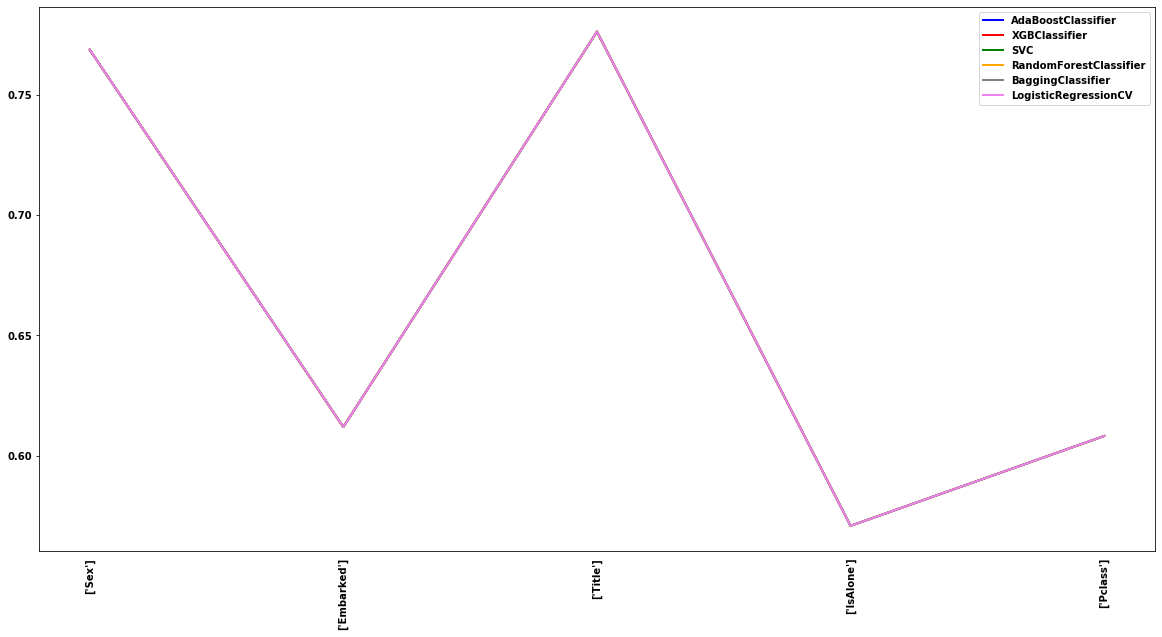

In [26]:
features_label =[str(feature_list[0]) for feature_list in features]

models_test_result = {}
for combination in metrics_all:
    for model in combination:
        if model not in models_test_result.keys():
             models_test_result[model] = []
        models_test_result[model].append(combination[model][1])

color_list = ['blue','red','green','orange','gray','violet']
plt.figure(figsize=(20,10))
x = list(range(len(features)))
for (model,color) in zip(models_test_result.keys(),color_list):
    plt.plot(x, models_test_result[model], label = model, color=color, linewidth=2.0)
plt.legend()
plt.xticks(list(range(len(features_label))), features_label, rotation='vertical')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True)  # labels along the bottom edge are off

* All categories should be turned to dummies
* Sex and Title are very important

### 3.b. Combination of features

### 3.b.i. Using all features

In [27]:
features = [
    [["Sex","Embarked","Title","IsAlone","Pclass"],
     ["Age","Fare",'FamilySize',
      'Age_bucket*Class','Fare_bucket*Class']]
]
    
models_all = []
metrics_all = []
categories_to_dummies_bool = True

for feature_list in features:
    
    categorical_features = feature_list[0]
    numerical_features = feature_list[1]
    print(numerical_features)

    train, test = preprocess(train_df,test_df,df_id,label,
                            categorical_features,numerical_features,
                            categories_to_dummies_bool)

    final_features =  list(set(train.columns)-set([label,df_id]))
    len(final_features)

    trained_model, metrics_result = training(models, train,final_features,  n_splits=5)
    
    models_all.append(trained_model)
    metrics_all.append(metrics_result)


['Age', 'Fare', 'FamilySize', 'Age_bucket*Class', 'Fare_bucket*Class']
DF shape after feature engineering:  (891, 19) (418, 18)
DF categorical features shape after label encoded:  (891, 19) (418, 18)
Categorical features are transformed as string.
DF categorical features shape after turned to dummies:  (891, 15) (418, 15)
DF final shape:  (891, 22) (418, 21)
Train : AdaBoostClassifier:0.8282504012841091
Test  : AdaBoostClassifier:0.7985074626865671

Train : XGBClassifier:0.8651685393258427
Test  : XGBClassifier:0.8246268656716418

Train : SVC:0.9245585874799358
Test  : SVC:0.6977611940298507

Train : RandomForestClassifier:0.8796147672552167
Test  : RandomForestClassifier:0.7574626865671642

Train : BaggingClassifier:0.9325842696629213
Test  : BaggingClassifier:0.8059701492537313

Train : LogisticRegressionCV:0.8346709470304976
Test  : LogisticRegressionCV:0.8059701492537313



In [28]:
voting_classifier(train_df,test_df, #0.78468
          categorical_features,numerical_features,
          models_all,combination_idx=0,
          include_all_models=False,
          to_csv=True,
          model_name = 'voting_classifier_topmodels_numeric_continuous'
          )

DF shape after feature engineering:  (891, 19) (418, 18)
DF categorical features shape after label encoded:  (891, 19) (418, 18)
Categorical features are transformed as string.
DF categorical features shape after turned to dummies:  (891, 15) (418, 15)
DF final shape:  (891, 22) (418, 21)
predicted # of survivors =  163


In [29]:
voting_classifier(train_df,test_df, #not submitted
          categorical_features,numerical_features,
          models_all,combination_idx=0,
          include_all_models=True,
          to_csv=False,
          model_name = 'voting_classifier_allmodels_numeric_continuous'
          )

DF shape after feature engineering:  (891, 19) (418, 18)
DF categorical features shape after label encoded:  (891, 19) (418, 18)
Categorical features are transformed as string.
DF categorical features shape after turned to dummies:  (891, 15) (418, 15)
DF final shape:  (891, 22) (418, 21)
predicted # of survivors =  150


##### Nested CV

In [30]:
features = [
    [["Sex","Embarked","Title","IsAlone","Pclass"],
     ["Age","Fare",'FamilySize',
      'Age_bucket*Class','Fare_bucket*Class']]
]
    
models_all = []
metrics_all = []
categories_to_dummies_bool = True

for feature_list in features:
    
    categorical_features = feature_list[0]
    numerical_features = feature_list[1]
    print(numerical_features)

    train, test = preprocess(train_df,test_df,df_id,label,
                            categorical_features,numerical_features,
                            categories_to_dummies_bool)

    final_features =  list(set(train.columns)-set([label,df_id]))
    len(final_features)

    trained_model, metrics_result = training_nestedCV(models, train,final_features,  n_splits=5)
    
    models_all.append(trained_model)
    metrics_all.append(metrics_result)


['Age', 'Fare', 'FamilySize', 'Age_bucket*Class', 'Fare_bucket*Class']
DF shape after feature engineering:  (891, 19) (418, 18)
DF categorical features shape after label encoded:  (891, 19) (418, 18)
Categorical features are transformed as string.
DF categorical features shape after turned to dummies:  (891, 15) (418, 15)
DF final shape:  (891, 22) (418, 21)
[Outer fold 1/5]
[Outer fold 2/5]
[Outer fold 3/5]
[Outer fold 4/5]
[Outer fold 5/5]
Train : AdaBoostClassifier:0.8409068345493799
Test  : AdaBoostClassifier:0.8091268595819472

[Outer fold 1/5]
[Outer fold 2/5]
[Outer fold 3/5]
[Outer fold 4/5]
[Outer fold 5/5]
Train : XGBClassifier:0.8827107332524387
Test  : XGBClassifier:0.8158809867553826

[Outer fold 1/5]
[Outer fold 2/5]
[Outer fold 3/5]
[Outer fold 4/5]
[Outer fold 5/5]
Train : SVC:0.9326595174685218
Test  : SVC:0.7306321009352834

[Outer fold 1/5]
[Outer fold 2/5]
[Outer fold 3/5]
[Outer fold 4/5]
[Outer fold 5/5]
Train : RandomForestClassifier:0.8973095954741005
Test  : Ra

In [31]:
voting_classifier(train_df,test_df, #0.79425
          categorical_features,numerical_features,
          models_all,combination_idx=0,
          include_all_models=False,
          to_csv=True,
          model_name = 'voting_classifier_topmodels_numeric_continuous_nestedcv'
          )

DF shape after feature engineering:  (891, 19) (418, 18)
DF categorical features shape after label encoded:  (891, 19) (418, 18)
Categorical features are transformed as string.
DF categorical features shape after turned to dummies:  (891, 15) (418, 15)
DF final shape:  (891, 22) (418, 21)
predicted # of survivors =  168


In [32]:
voting_classifier(train_df,test_df, #not submitted
          categorical_features,numerical_features,
          models_all,combination_idx=0,
          include_all_models=True,
          to_csv=False,
          model_name = 'voting_classifier_allmodels_numeric_continuous_nestedcv'
          )

DF shape after feature engineering:  (891, 19) (418, 18)
DF categorical features shape after label encoded:  (891, 19) (418, 18)
Categorical features are transformed as string.
DF categorical features shape after turned to dummies:  (891, 15) (418, 15)
DF final shape:  (891, 22) (418, 21)
predicted # of survivors =  145


In [33]:
trained_model = models_all[0] #0.78947
model_name="LogisticRegressionCV"
create_submission(
              trained_model,model_name,
              train_df,test_df,
              categorical_features,
              numerical_features,
              to_csv =True,
              prefix='all_features_nonbucket_nestedcv_')

DF shape after feature engineering:  (891, 19) (418, 18)
DF categorical features shape after label encoded:  (891, 19) (418, 18)
Categorical features are transformed as string.
DF categorical features shape after turned to dummies:  (891, 15) (418, 15)
DF final shape:  (891, 22) (418, 21)
# of predicted survivors: 169, avg: 0.4043062200956938


169

##### Not using StratiFiedKFold and not using NestedCV

In [34]:
voting_classifier(train_df,test_df,  #0.79425
          categorical_features,numerical_features,
          models_all,combination_idx=0,
          include_all_models=False,
          to_csv=True,
          model_name = 'voting_classifier_topmodels_numeric_continuous'
          )

DF shape after feature engineering:  (891, 19) (418, 18)
DF categorical features shape after label encoded:  (891, 19) (418, 18)
Categorical features are transformed as string.
DF categorical features shape after turned to dummies:  (891, 15) (418, 15)
DF final shape:  (891, 22) (418, 21)
predicted # of survivors =  168
